In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from SimPEG import Mesh, Utils, Maps
from discretize import utils

import casingSimulations

%matplotlib inline

In [2]:
simDir = 'Compare_3D_HED'

## set up a wholeSpace

In [3]:
sigma_back = 1e-1

cyl_cp = casingSimulations.CasingParameters(
    sigma_casing = sigma_back, 
    sigma_inside = sigma_back,
    sigma_layer = sigma_back,
    sigma_back = sigma_back,
    sigma_air = sigma_back, 
    mur_casing = 1., 
    src_a = np.r_[490., np.pi, 5.],
    src_b = np.r_[510., np.pi, 5.],
    freqs = [1.],
)

In [4]:
cyl_cp.save(directory=simDir, filename="cyl_cp.json")

In [5]:
npadx, npadz = 9, 9
dx2 = 1000. 
csx = 20.
csz = 20.

ncy = 3
nstretchy = 4
stretchfact = 1.6
hy = utils.meshTensor(
    [(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)]
)
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CylMeshGenerator(
    cp=cyl_cp, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x=dx2, 
    hy=hy, 
    csx=csx, 
    csz=csz
)

In [6]:
cylMeshGen.save(directory=simDir, filename="cyl_mesh.json")

In [7]:
cylmesh = cylMeshGen.mesh

//anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


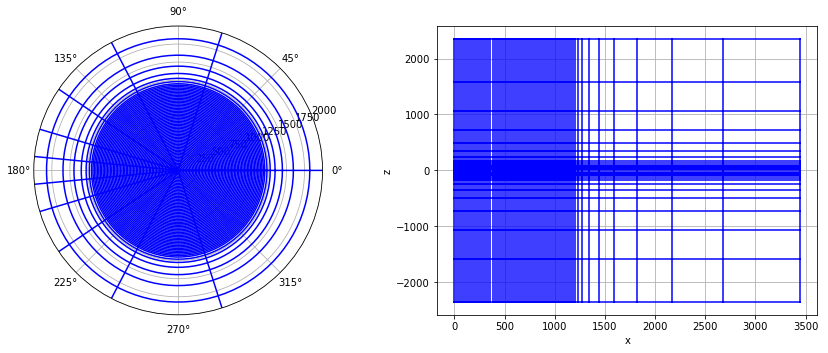

In [8]:
fig = plt.figure(figsize=(12, 5))
ax0 = plt.subplot(121, projection='polar')
ax1 = plt.subplot(122)

ax0.set_rlim([0.,2e3])

cylmesh.plotGrid(ax=[ax0, ax1])

In [9]:
cyl_cp.skin_depth()

array([ 1591.54943092])

In [10]:
src = casingSimulations.sources.HorizontalElectricDipole(cyl_cp, cylmesh)

(0.0, 1200.0)

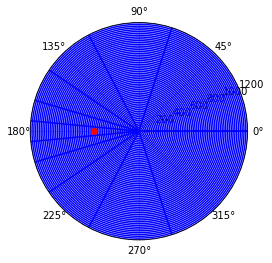

In [11]:
ax = plt.subplot(111, projection='polar')
cylmesh.plotGrid(ax=ax, slice='z')
ax.plot(cylmesh.gridFx[src.surface_wire,1], cylmesh.gridFx[src.surface_wire,0], 'ro')
ax.set_rlim([0., 1200.])

(-100.0, 100.0)

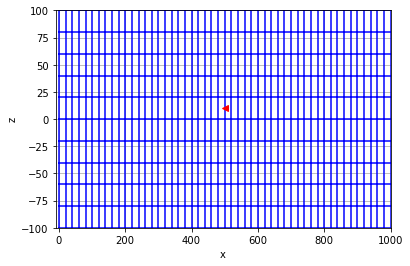

In [12]:
fig, ax = plt.subplots(1, 1)
cylmesh.plotGrid(ax=ax, slice='theta')
src.plot(ax=ax)

ax.set_xlim([-10., 1000.])
ax.set_ylim([-100., 100.])

In [13]:
src.validate()

In [14]:
cylMesh= casingSimulations.load_properties('/'.join([simDir, 'cyl_mesh.json']))
cyl_cp = casingSimulations.load_properties('/'.join([simDir, 'cyl_cp.json']))
cyl_hfield = np.load('/'.join([simDir, 'fieldsCyl.npy']))

In [15]:
cylmesh = cylMesh.mesh

In [16]:
cylSimulation = casingSimulations.run.SimulationFDEM(cyl_cp, cylMesh, 'HorizontalElectricDipole')
cylSimulation.prob.model = cylSimulation.physprops.model
cylFields = cylSimulation.prob.fieldsPair(cylMesh.mesh, cylSimulation.survey)

In [17]:
cylFields[:,'hSolution'] = cyl_hfield

In [18]:
jcyl = cylFields[:,'j']

In [19]:
theta_ind = 0
jplt = casingSimulations.face3DthetaSlice(cylMesh.mesh, jcyl, theta_ind=theta_ind)

In [20]:
mesh2D = Mesh.CylMesh([cylMesh.mesh.hx, 1., cylMesh.mesh.hz], x0=cylMesh.mesh.x0)

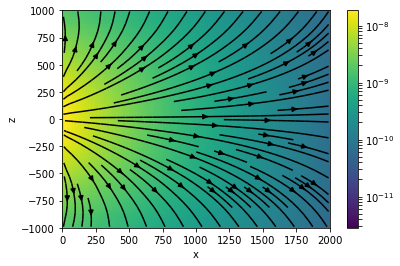

In [21]:
fig, ax = plt.subplots(1,1)
casingSimulations.plotFace2D(
    mesh2D,
    jplt, real_or_imag='real', ax=ax, range_x=np.r_[0., 2000.],
    range_y=np.r_[-1000., 1000.], sample_grid=np.r_[20., 20.],
    logScale=True
)

In [22]:
from SimPEG.EM import Analytics

In [23]:
theta = cylmesh.vectorCCy[theta_ind]

gridFx = mesh2D.gridFx
gridFx[:,1] = theta

gridFz = mesh2D.gridFz
gridFz[:,1] = theta

gridFx = utils.cyl2cart(gridFx)
gridFz = utils.cyl2cart(gridFz)

eana_x, eana_y, _ = Analytics.E_from_ElectricDipoleWholeSpace(
    gridFx, np.r_[-500., 0., 12.5], sig=cyl_cp.sigma_back, f=cyl_cp.freqs, current=1., 
    length=20., orientation='X'
)

_, _, eana_z = Analytics.E_from_ElectricDipoleWholeSpace(
    gridFz, np.r_[-500., 0., 12.5], sig=cyl_cp.sigma_back, f=cyl_cp.freqs, current=1., 
    length=20., orientation='X'
)

eana_x = (np.cos(theta) * eana_x + np.sin(theta) * eana_y)

# re-arranging to account for plotting on a mesh where x=0 ir the origin. 
# if np.cos(theta) > 0.:
# eana_x = utils.mkvc(np.fliplr(eana_x.reshape(mesh2D.vnFx[0], mesh2D.vnFx[2], order='F')))
# eana_z = utils.mkvc(np.fliplr(eana_z.reshape(mesh2D.vnFz[0], mesh2D.vnFz[2], order='F')))

eana = utils.mkvc(np.hstack([eana_x, eana_z]),2)

                
jana = cyl_cp.sigma_back * eana

In [24]:
[-1 if np.cos(theta) < 0. else 1]

[1]

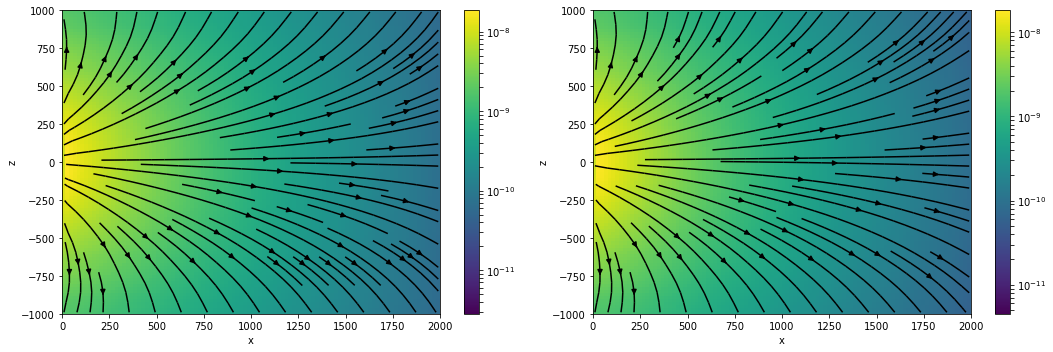

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

casingSimulations.plotFace2D(
    mesh2D,
    jplt, real_or_imag='real', ax=ax[0], range_x=np.r_[0., 2000.],
    range_y=np.r_[-1000., 1000.], sample_grid=np.r_[20., 20.],
    logScale=True
)

casingSimulations.plotFace2D(
    mesh2D,
    jana, real_or_imag='real', ax=ax[1], range_x=np.r_[0., 2000.],
    range_y=np.r_[-1000., 1000.], sample_grid=np.r_[20., 20.],
    logScale=True
)

plt.tight_layout()

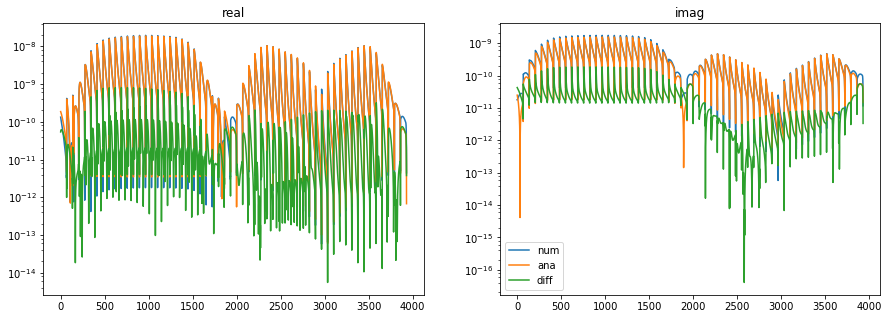

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].semilogy(np.absolute(jplt.real))
ax[0].semilogy(np.absolute(jana.real))
ax[0].semilogy(np.absolute(jplt.real - jana.real))
ax[0].set_title('real')

ax[1].semilogy(np.absolute(jplt.imag))
ax[1].semilogy(np.absolute(jana.imag))
ax[1].semilogy(np.absolute(jplt.imag - jana.imag))
ax[1].set_title('imag')

ax[1].legend(['num', 'ana', 'diff'])